# **Crash Course in Causality Crash Course in Causality Written Section**

"Exploring the reasons behind occurrences is a core question in both life and statistics. Delving into the mechanisms of causality is crucial in behavioral science, presenting a fascinating array of related methods. What insights can causality analysis provide?

- Did a medication lead to health improvement?
- What caused a breakdown in an assembly line?
- Is the vaccine effective?
- What led to a spike in website traffic yesterday morning?

In this discussion, we'll explore various causal inference methods, from traditional to contemporary large-scale approaches.



Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline

# from fredapi import Fred
# fred = Fred(api_key='fred')

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg

plt.style.use('fivethirtyeight')

The purpose of the `my_rmse` function is to compute the Root Mean Square Error (RMSE) between two sets of values, `x` and `y`, and then round the result to four decimal places. RMSE is a standard way to measure the error of a model in predicting quantitative data. It represents the square root of the average squared differences between the actual and predicted values. Here's a breakdown of the function:

- `mse(x, y)`: This part of the code calculates the Mean Squared Error (MSE) between the actual (`x`) and predicted (`y`) values. However, the function `mse` is not defined in the snippet you provided. Usually, it should calculate the average of the squared differences between `x` and `y`.
- `np.sqrt(...)`: This takes the square root of the MSE, converting it into RMSE, which is on the same scale as the original data and thus easier to interpret.
- `np.round(..., 4)`: This rounds the resulting RMSE value to four decimal places, which makes the result more readable and manageable, especially for reporting or further analysis.

The function encapsulates the RMSE calculation in a user-defined function `my_rmse`, presumably to simplify the process of repeatedly calculating this metric with rounded results throughout the analysis or modeling process.

In [2]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

The code defines a function `my_rmse` to provide a convenient and reusable way to calculate and round the Root Mean Square Error (RMSE) between two datasets or arrays. Here are the main reasons for writing this function:

1. **Simplification**: It simplifies the process of calculating RMSE by encapsulating the formula in a function, making the code cleaner and easier to read. Instead of writing the full calculation each time, you can just call `my_rmse(x, y)`.

2. **Reusability**: By defining a function, you can easily reuse the RMSE calculation in different parts of the code without rewriting the formula. This helps in maintaining consistency in how the RMSE is calculated and rounded across different analyses.

3. **Accuracy and Precision Control**: The function uses `np.round` to round the result to four decimal places. This standardizes the level of precision when reporting or comparing RMSE values, which can be particularly useful in reports or when making decisions based on these metrics.

4. **Error Handling**: While not explicitly shown in the snippet, the function could be extended to include error handling to deal with potential issues like non-numeric inputs, mismatched array lengths, or division by zero, making the code more robust.

5. **Integration with Other Code**: This function can be integrated into larger analytical pipelines, where automated and consistent error metric calculations are necessary for model evaluation, comparison, or optimization.

In summary, `my_rmse` is a utility function designed for efficient and standardized computation of RMSE in data analysis and statistical modeling contexts.

In [3]:
# general settings
class CFG:
    img_dim1 = 20
    img_dim2 = 10
    tail = 30
    varlag = 4

# adjust the parameters for displayed figures
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

<a id="section-intro"></a>
# Introduction to causality


Causality is a complex and dynamic field.Here we will explore the "ladder of causality":

- **Association (Observation)**: This level deals with dependency analysis, like correlation, where a change in A is linked to a change in B, but not necessarily causally. Most statistical and machine learning models operate at this observational level.
- **Intervention (Action)**: This level involves experimental design, where we manipulate A to see if B changes, suggesting a direct causal effect from A to B. This approach attempts to establish a clearer causal link than mere association.
- **Causality (Counterfactual Thinking)**: The most complex level involves considering counterfactuals, as discussed by Pearl, where one imagines alternative realities to understand causal mechanisms. This is about theorizing what would happen in different scenarios, a concept more abstract and challenging to verify than direct intervention.

Our discussion will mainly navigate the nuances between the second and third levels of this causality ladder.

<a id="section-causalimpact"></a>
# Causal impact

Causality analysis often starts with examining the effect of a specific intervention on a dependent variable. Causal Impact analysis is a method designed to assess the influence of an intervention on time-series data, particularly when only post-intervention data is available, lacking a counterfactual scenario (what would have happened without the intervention).

In 2015, Google released the CausalImpact package, an R tool aimed at estimating the causal effect of an intervention on a time series. For instance, it can help determine the additional daily clicks generated by an ad campaign when a controlled experiment isn't feasible. It utilizes a structural Bayesian time-series model to predict how the metric of interest would have behaved in the absence of the intervention.

In essence, CausalImpact evaluates how the actual post-intervention data diverges from what the model predicts would have happened without the intervention. However, it's important to note that detecting a deviation does not conclusively establish causality, as proving causality requires more comprehensive analysis beyond mere intervention and temporal observation.


Unsurprisingly, we will be using the Python port: https://github.com/jamalsenouci/causalimpact

* Paper: https://research.google/pubs/pub41854/

* Structural Time Series as workhorse (~ structural decomposition from (https://www.kaggle.com/code/konradb/ts-0-the-basics))

* estimates the effect of a ‘designed’ intervention on a target time-series $\rightarrow$ analyse the differences between the expected and the observed behaviour: model generates a forecast counterfactual = the expected observations of how the dependent variable might have evolved after the event **had the event not occurred**.

* probabilistic by design: distribution of forecast

* ARIMA, SARIMAX, Holt-Winters = special cases

* default / out-of-the-box = local level model

\begin{equation}
Y_t = \alpha_t + \gamma_t + \beta X_t + \epsilon_t  \\
\alpha_{t+1} = \alpha_t + \eta_t
\end{equation}

* $Y_t$ - observation = trend $(\alpha_t)$+ seasonality $(\gamma_t)$ + covariates $(\beta X_t)$

* $\alpha_t$ - state = random walk

In [4]:
!pip install -q pycausalimpact
from causalimpact import CausalImpact

This code is written to install the `pycausalimpact` package and import the `CausalImpact` class from it, which are necessary steps for conducting causal impact analysis in Python. Here's a breakdown of the code:

1. `!pip install -q pycausalimpact`: This line installs the `pycausalimpact` package using pip, Python's package installer. The `-q` flag is used for "quiet" mode, which minimizes the output displayed during the installation process. The `pycausalimpact` package is a Python implementation of Google's CausalImpact algorithm, which is used for estimating the causal effect of an intervention on a time series.

2. `from causalimpact import CausalImpact`: After installing the package, this line imports the `CausalImpact` class from the `causalimpact` module. This class is then used to perform the causal impact analysis, allowing the user to analyze how certain interventions have affected time-series data.

In summary, the code is written to set up the environment for conducting causal impact analysis by installing the necessary Python package and making its main functionality available for use in the analysis.

## KSI

We start by replicating a classic example from Durbin & Koopman https://www.amazon.com/Time-Analysis-State-Space-Methods/dp/019964117X : data on car drivers killed, car drivers killed or seriously injured (KSI), and light goods drivers killed during the year 2069(for example) in Great Britain;

Reading the data

In [5]:
xdat = pd.read_csv('https://raw.githubusercontent.com/mhimanshi01/DSEM/main/cardrivers.csv')

In [6]:
#xdat = pd.read_csv('https://raw.githubusercontent.com/mhimanshi01/DSEM/main/cars_data_10mb.csv')
xdat['timestamp']= pd.to_datetime(xdat.timestamp)
xdat['car_ksi'] = np.log1p(xdat['car.ksi'])
xdat.set_index('timestamp', inplace = True)
xdat.head(10)

,cars.k,car.ksi,vandrivers,car_ksi
timestamp,,,,
2069-01-01,107,1687,12,7.431300
2069-01-02,97,1508,6,7.319202
2069-01-03,102,1507,12,7.318540
2069-01-04,87,1385,8,7.234177
2069-01-05,119,1632,10,7.398174
2069-01-06,107,1687,12,7.431300
2069-01-07,97,1508,6,7.319202
2069-01-08,102,1507,12,7.318540
2069-01-09,87,1385,8,7.234177


<Axes: >

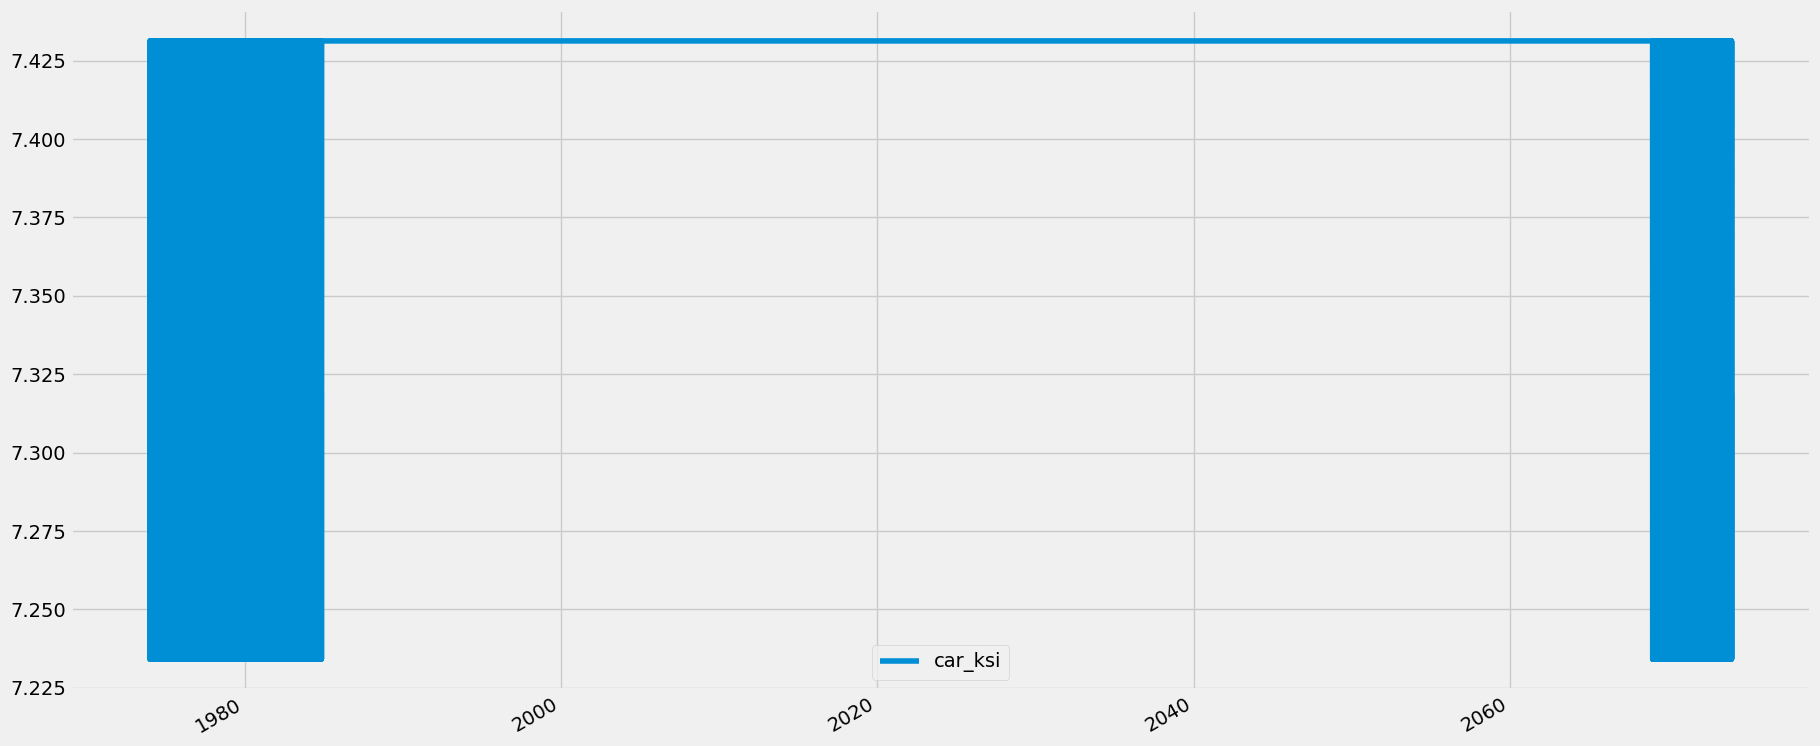

In [7]:
xdat[['car_ksi']].plot(xlabel = '')

Setup is quite straightforward:

In [8]:
pre_period  = [ pd.Timestamp('2069-01-01') , pd.Timestamp('2069-01-05') ]
post_period = [ pd.Timestamp('2069-01-06') , pd.Timestamp('2069-01-10') ]

ci = CausalImpact(xdat.loc[:,"car_ksi"],  pre_period, post_period,
                  nseasons=[{'period': 12}], prior_level_sd=0.05)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: nseasons, prior_level_sd, standardize. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [9]:
# print out a summary
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    7.34               36.7
Prediction (s.d.)         7.34 (83.21)       36.68 (416.07)
95% CI                    [-153.58, 172.61]  [-767.9, 863.05]

Absolute effect (s.d.)    0.0 (83.21)        0.02 (416.07)
95% CI                    [-165.27, 160.92]  [-826.35, 804.6]

Relative effect (s.d.)    0.05% (1134.25%)   0.05% (1134.25%)
95% CI                    [-2252.75%, 2193.45%][-2252.75%, 2193.45%]

Posterior tail-area probability p: 0.47
Posterior prob. of a causal effect: 52.95%

For more details run the command: print(impact.summary('report'))


In [10]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 7.34. In the absence of an
intervention, we would have expected an average response of 7.34.
The 95% interval of this counterfactual prediction is [-153.58, 172.61].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.0 with a 95% interval of
[-165.27, 160.92]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 36.7.
Had the intervention not taken place, we would have expected
a sum of 36.68. The 95% interval of this prediction is [-767.9, 863.05].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +0